In [49]:
pip install collision

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [66]:
import collision
import pygame
import random
import operator
from itertools import combinations
from collision import *
import physics as pf
import pygame.gfxdraw
from itertools import combinations

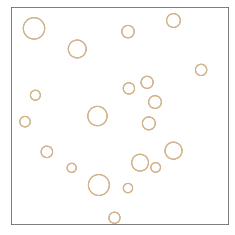

In [71]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.patches import Circle
from matplotlib import animation
from itertools import combinations
from matplotlib.animation import FuncAnimation, PillowWriter
from IPython.display import HTML
from matplotlib import rc

class Particle:
    """A class representing a two-dimensional particle."""

    def __init__(self, x, y, vx, vy, radius=0.01, styles=None):
        """Initialize the particle's position, velocity, and radius.
        Any key-value pairs passed in the styles dictionary will be passed
        as arguments to Matplotlib's Circle patch constructor.
        """

        self.r = np.array((x, y))
        self.v = np.array((vx, vy))
        self.radius = radius
        self.mass = self.radius**2

        self.styles = styles
        if not self.styles:
            # Default circle styles
            self.styles = {'edgecolor': 'b', 'fill': False}

    # For convenience, map the components of the particle's position and
    # velocity vector onto the attributes x, y, vx and vy.
    @property
    def x(self):
        return self.r[0]
    @x.setter
    def x(self, value):
        self.r[0] = value
    @property
    def y(self):
        return self.r[1]
    @y.setter
    def y(self, value):
        self.r[1] = value
    @property
    def vx(self):
        return self.v[0]
    @vx.setter
    def vx(self, value):
        self.v[0] = value
    @property
    def vy(self):
        return self.v[1]
    @vy.setter
    def vy(self, value):
        self.v[1] = value

    def overlaps(self, other):
        """Does the circle of this Particle overlap that of other?"""

        return np.hypot(*(self.r - other.r)) < self.radius + other.radius

    def draw(self, ax):
        """Add this Particle's Circle patch to the Matplotlib Axes ax."""

        circle = Circle(xy=self.r, radius=self.radius, **self.styles)
        ax.add_patch(circle)
        return circle

    def advance(self, dt):
        """Advance the Particle's position forward in time by dt."""

        self.r += self.v * dt

class Simulation:
    """A class for a simple hard-circle molecular dynamics simulation.
    The simulation is carried out on a square domain: 0 <= x < 1, 0 <= y < 1.
    """

    ParticleClass = Particle

    def __init__(self, n, radius=0.01, styles=None):
        """Initialize the simulation with n Particles with radii radius.
        radius can be a single value or a sequence with n values.
        Any key-value pairs passed in the styles dictionary will be passed
        as arguments to Matplotlib's Circle patch constructor when drawing
        the Particles.
        """

        self.init_particles(n, radius, styles)
        self.dt = 0.01

    def place_particle(self, rad, styles):
        # Choose x, y so that the Particle is entirely inside the
        # domain of the simulation.
        x, y = rad + (1 - 2*rad) * np.random.random(2)
        # Choose a random velocity (within some reasonable range of
        # values) for the Particle.
        vr = 0.1 * np.sqrt(np.random.random()) + 0.05
        vphi = 2*np.pi * np.random.random()
        vx, vy = vr * np.cos(vphi), vr * np.sin(vphi)
        particle = self.ParticleClass(x, y, vx, vy, rad, styles)
        # Check that the Particle doesn't overlap one that's already
        # been placed.
        for p2 in self.particles:
            if p2.overlaps(particle):
                break
        else:
            self.particles.append(particle)
            return True
        return False

    def init_particles(self, n, radius, styles=None):
        """Initialize the n Particles of the simulation.
        Positions and velocities are chosen randomly; radius can be a single
        value or a sequence with n values.
        """

        try:
            iterator = iter(radius)
            assert n == len(radius)
        except TypeError:
            # r isn't iterable: turn it into a generator that returns the
            # same value n times.
            def r_gen(n, radius):
                for i in range(n):
                    yield radius
            radius = r_gen(n, radius)

        self.n = n
        self.particles = []
        for i, rad in enumerate(radius):
            # Try to find a random initial position for this particle.
            while not self.place_particle(rad, styles):
                pass

    def change_velocities(self, p1, p2):
        """
        Particles p1 and p2 have collided elastically: update their
        velocities.
        """
        
        m1, m2 = p1.mass, p2.mass
        M = m1 + m2
        r1, r2 = p1.r, p2.r
        d = np.linalg.norm(r1 - r2)**2
        v1, v2 = p1.v, p2.v
        u1 = v1 - 2*m2 / M * np.dot(v1-v2, r1-r2) / d * (r1 - r2)
        u2 = v2 - 2*m1 / M * np.dot(v2-v1, r2-r1) / d * (r2 - r1)
        p1.v = u1
        p2.v = u2

    def handle_collisions(self):
        """Detect and handle any collisions between the Particles.
        When two Particles collide, they do so elastically: their velocities
        change such that both energy and momentum are conserved.
        """ 

        # We're going to need a sequence of all of the pairs of particles when
        # we are detecting collisions. combinations generates pairs of indexes
        # into the self.particles list of Particles on the fly.
        pairs = combinations(range(self.n), 2)
        for i,j in pairs:
            if self.particles[i].overlaps(self.particles[j]):
                self.change_velocities(self.particles[i], self.particles[j])

    def handle_boundary_collisions(self, p):
        """Bounce the particles off the walls elastically."""

        if p.x - p.radius < 0:
            p.x = p.radius
            p.vx = -p.vx
        if p.x + p.radius > 1:
            p.x = 1-p.radius
            p.vx = -p.vx
        if p.y - p.radius < 0:
            p.y = p.radius
            p.vy = -p.vy
        if p.y + p.radius > 1:
            p.y = 1-p.radius
            p.vy = -p.vy

    def apply_forces(self):
        """Override this method to accelerate the particles."""
        pass

    def advance_animation(self):
        """Advance the animation by dt, returning the updated Circles list."""

        for i, p in enumerate(self.particles):
            p.advance(self.dt)
            self.handle_boundary_collisions(p)
            self.circles[i].center = p.r
        self.handle_collisions()
        self.apply_forces()
        return self.circles

    def advance(self):
        """Advance the animation by dt."""
        for i, p in enumerate(self.particles):
            p.advance(self.dt)
            self.handle_boundary_collisions(p)
        self.handle_collisions()
        self.apply_forces()

    def init(self):
        """Initialize the Matplotlib animation."""

        self.circles = []
        for particle in self.particles:
            self.circles.append(particle.draw(self.ax))
        return self.circles

    def animate(self, i):
        """The function passed to Matplotlib's FuncAnimation routine."""

        self.advance_animation()
        return self.circles

    def setup_animation(self):
        self.fig, self.ax = plt.subplots()
        for s in ['top','bottom','left','right']:
            self.ax.spines[s].set_linewidth(0.5)
        self.ax.set_aspect('equal', 'box')
        self.ax.set_xlim(0, 1)
        self.ax.set_ylim(0, 1)
        self.ax.xaxis.set_ticks([])
        self.ax.yaxis.set_ticks([])

    def save_or_show_animation(self, anim, save, filename='collision.mp4'):
        if save:
            Writer = animation.writers['ffmpeg']
            writer = Writer(fps=10, bitrate=1800)
            anim.save(filename, writer=writer)
        else:
            plt.show()

    def do_animation(self, save=False, interval=1, filename='collision.mp4'):
        """Set up and carry out the animation of the molecular dynamics.
        To save the animation as a MP4 movie, set save=True.
        """

        self.setup_animation()
        anim = animation.FuncAnimation(self.fig, self.animate,
                init_func=self.init, frames=800, interval=interval, blit=True)
        anim.save("brown.gif", dpi=250, writer=PillowWriter(fps=20))
        self.save_or_show_animation(anim, save, filename)


if __name__ == '__main__':
    nparticles = 20
    radii = np.random.random(nparticles)*0.03+0.02
    styles = {'edgecolor': 'tan', 'linewidth': 1, 'fill': None}
    sim = Simulation(nparticles, radii, styles)
    sim.do_animation(save=True, filename='brownian.mp4')